In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.losses
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## First the assisting functions and classes used in the model

In [2]:
def error_autocorrelation(error):
    """
    error : np.array
    """
    e_t = error[1:]
    e_tminus = error[:-1]
    linear_model = sm.OLS(e_t,e_tminus, hasconst=False)
    linear_model_res = linear_model.fit()
    param = linear_model_res.params[0]
    conf_int_low, conf_int_high = linear_model_res.conf_int()[0]
    return param, conf_int_low, conf_int_high

In [3]:
class TransformLSTM():
    """
    Attributes
    ==========
    sequence_length : (int):
        length of sequences

    Methods
    =======
    preprocess_data : creates features for LSTM
    L_tilde_pad : Pads LSTM prediction (the first part)
    """

    def __init__(self, sequence_length, min_val=None, max_val=None, std=None, mean=None):
        self.sequence_length = sequence_length
        self.min_val = min_val
        self.max_val = max_val
        self.mean = mean
        self.std = std

    def preprocess_data(self, X):

        """makes <sequence_length> len sequences, using the target as the next incomming value"""

        LEN_SEQ = self.sequence_length + 1

        #using X is a 1d-array
        len_X = X.size


        features = list()

        #creating features
        for i in range(LEN_SEQ):

            end = LEN_SEQ-i
            X_tmp = X[i:- end]

            if end!=1:
                features.append((X_tmp,))
            else:
                target = X_tmp

        features = np.array(features).T

        # normalizing

        if self.mean == None:
            _mean = np.mean(features)
        else:
            _mean = self.mean

        if self.std == None:
            _std = np.std(features)
        else:
            _std = self.std

        if (self.min_val != None) and (self.max_val != None) :
            _dist = self.max_val - self.min_val
        else:
            _dist = np.max(features) - np.min(features)

        moments = {'std': _std, 'mean': _mean, 'dist': _dist}
        features = (features - _mean) / _dist
        target = (target - _mean) / _dist
        return features, target, moments

    def L_tilde_pad(self, L_tilde):
        """takes first observation and pads before with it"""
        LEN_SEQ = self.sequence_length + 1
        padding = [L_tilde[0] for _ in range(LEN_SEQ)]
        L_tilde = np.append(padding, L_tilde)
        return L_tilde

    def calc_error(self, X, D_tilde, L_tilde):
        #have to subset len of sequence to get dimensions to fit
        LEN_SEQ = self.sequence_length + 1
        error = X[LEN_SEQ:] - D_tilde[LEN_SEQ:] - L_tilde
        return error

## Data loading and preperation

In [4]:
df = pd.read_pickle('data/top15.pkl')

In [5]:
year = np.array(df.index.year, dtype=float)
year[year == 2014] = 3.51
year[year == 2015] = 14.42
year[year == 2016] = 9.35
year[year == 2017] = 6.30
year[year == 2018] = 9.29

In [6]:
df = df.drop(['flow_shift24', 'flow_shift25'], axis=1)

In [7]:
_min_val, _max_val, _mean, _std = np.min(df['flow']), np.max(df['flow']), np.mean(df['flow']), np.std(df['flow'])
_min_val, _max_val, _mean, _std

(-9.352128969088266, 132.0678710309118, 54.831062087607535, 25.738916847723793)

In [8]:
separation_date_train = datetime.datetime(2017,10,15)
separation_date_test = datetime.datetime(2017,11,20)

df_train = df.loc[df.index < separation_date_train]
df_test = df.loc[df.index > separation_date_test]

W, X = df_train.drop(['flow'], axis=1), df_train['flow']
_W, _X = df_test.drop(['flow'], axis=1), df_test['flow']

W_comp, X_comp = df.drop(['flow'], axis=1), df['flow']

## The model part

In [9]:
## Model configuration:

# number of model loops:
s = 3

# number of epochs:
epochs = 70

# batch size
bs = 90

In [10]:
N_OBS = len(X)

#model
gb = GradientBoostingRegressor(n_estimators=500)

#step 1 (initialize)
L_tilde = year[0:N_OBS]

mse_trues, mse_rf_intermediates = list(), list()
params, low_confs, high_confs = list(), list(), list()
 
for iteration in range(s):
    
    ### STEP 2 - DEMAND ESTIMATION ####
    
    # A) fitting model
    D_tmp = X - L_tilde
    W_train, W_test, D_train, D_test = train_test_split(W, D_tmp, test_size=0.25)
    gb.fit(W_train, D_train)

    # b) performance Out-of-Sample
    _pred_rf = gb.predict(W_test)
    mse_rf_intermediate = np.mean((_pred_rf - D_test)**2)

    # c) predict
    D_tilde = gb.predict(W)
    
    # d) scaling

    D_scale = gb.predict(W_comp)

    ### STEP 3 - LEAK ESTIMATION ####

    _min_val, _max_val = np.min(D_scale), np.max(D_scale) 
    _std, _mean = np.std(D_scale), np.mean(D_scale)

    # a) transformer
    transformer = TransformLSTM(bs, min_val = _min_val, max_val = _max_val, mean = _mean, std = _std)
    
    
    # b) fitting model
    L_tmp = X - D_tilde

    lstm = Sequential()
    lstm.add(LSTM((1), batch_input_shape=(None, 1, bs), return_sequences=True, dropout=0.2, recurrent_dropout=0.5))
    lstm.add(LSTM((1), input_shape=(None, 1, bs), return_sequences=True, dropout=0.25, recurrent_dropout=0.5))
    lstm.add(LSTM((1), return_sequences=False, dropout=0.3, recurrent_dropout=0.5 ))
    lstm.add(Dense(1))

    features, target, moments = transformer.preprocess_data(L_tmp)

    # poor naming (but good with regards to standard ml conventions)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

    lstm.compile(optimizer = 'rmsprop', loss='msle', metrics=['mse'])
    history = lstm.fit(X_train, y_train, epochs=epochs, validation_data = [X_test, y_test])

    # c) predicting (not predicting Out-Of-Sample)
    # important with reshape for performance!
    lstm_pred = np.array(lstm.predict(features), dtype='float64').reshape(-1)
    
    L_tilde = lstm_pred  * moments['dist'] + moments['mean']
    
    ### STEP 4 - VALIDATION ###

    # autocorrelation of errors

    #have to subset len of sequence
    error = transformer.calc_error(X, D_tilde, L_tilde)
    
    L_tilde = np.hstack([np.zeros(bs+1), L_tilde])

W0808 11:15:27.425210 140735886812032 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 26384 samples, validate on 6597 samples
Epoch 1/70
26384/26384 [==============================] - 15s 553us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 2/70
26384/26384 [==============================] - 10s 362us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 3/70
26384/26384 [==============================] - 10s 365us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 4/70
26384/26384 [==============================] - 10s 362us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 5/70
26384/26384 [==============================] - 9s 349us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 6/70
26384/26384 [==============================] - 9s 349us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 7/70
26384/26384 [==============================] - 9

26384/26384 [==============================] - 12s 470us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 56/70
26384/26384 [==============================] - 15s 562us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 57/70
26384/26384 [==============================] - 11s 417us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 58/70
26384/26384 [==============================] - 9s 356us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 59/70
26384/26384 [==============================] - 9s 332us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 60/70
26384/26384 [==============================] - 11s 425us/sample - loss: 1.0420e-04 - mse: 0.1254 - val_loss: 8.8887e-05 - val_mse: 0.1244
Epoch 61/70
26384/26384 [==============================] - 11s 433us/sample - loss: 1.0420e-04 - mse: 0.1254 - val

26384/26384 [==============================] - 10s 374us/sample - loss: 0.0025 - mse: 0.0048 - val_loss: 0.0022 - val_mse: 0.0043
Epoch 42/70
26384/26384 [==============================] - 10s 379us/sample - loss: 0.0025 - mse: 0.0047 - val_loss: 0.0023 - val_mse: 0.0044
Epoch 43/70
26384/26384 [==============================] - 10s 370us/sample - loss: 0.0025 - mse: 0.0047 - val_loss: 0.0023 - val_mse: 0.0044
Epoch 44/70
26384/26384 [==============================] - 10s 376us/sample - loss: 0.0025 - mse: 0.0048 - val_loss: 0.0021 - val_mse: 0.0041
Epoch 45/70
26384/26384 [==============================] - 10s 368us/sample - loss: 0.0025 - mse: 0.0048 - val_loss: 0.0022 - val_mse: 0.0043
Epoch 46/70
26384/26384 [==============================] - 10s 368us/sample - loss: 0.0025 - mse: 0.0047 - val_loss: 0.0021 - val_mse: 0.0041
Epoch 47/70
26384/26384 [==============================] - 10s 374us/sample - loss: 0.0025 - mse: 0.0048 - val_loss: 0.0023 - val_mse: 0.0044
Epoch 48/70
26384/

26384/26384 [==============================] - 11s 425us/sample - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0023 - val_mse: 0.0047
Epoch 29/70
26384/26384 [==============================] - 11s 423us/sample - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 30/70
26384/26384 [==============================] - 11s 428us/sample - loss: 0.0027 - mse: 0.0055 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 31/70
26384/26384 [==============================] - 11s 426us/sample - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0023 - val_mse: 0.0046
Epoch 32/70
26384/26384 [==============================] - 12s 436us/sample - loss: 0.0028 - mse: 0.0055 - val_loss: 0.0023 - val_mse: 0.0047
Epoch 33/70
26384/26384 [==============================] - 12s 448us/sample - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0024 - val_mse: 0.0049
Epoch 34/70
26384/26384 [==============================] - 12s 451us/sample - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0023 - val_mse: 0.0047
Epoch 35/70
26384/

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


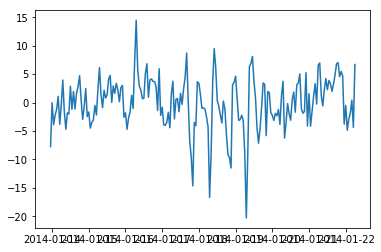

In [11]:
plt.plot(error[100:300])

In [12]:
np.mean(error)

-0.05639383960742186

In [13]:
# c) predict
D_tilde = gb.predict(_W)

# a) fitting model
L_tmp = _X - D_tilde

features, target, moments = transformer.preprocess_data(L_tmp)

# important with reshape for performance!
lstm_pred = np.array(lstm.predict(features), dtype='float64').reshape(-1)

L_tilde = (lstm_pred * moments['dist']) + moments['mean']

### STEP 3 - VALIDATION ###

# autocorrelation of errors

#have to subset len of sequence
error = transformer.calc_error(_X, D_tilde, L_tilde)

L_tilde = transformer.L_tilde_pad(L_tilde)
mse_true = np.mean(error**2)
param, conf_int_low, conf_int_high = error_autocorrelation(np.array(error))

lstm_test_res = [mse_true, param, conf_int_low, conf_int_high]

In [14]:
np.mean(error)

0.7651030199336194

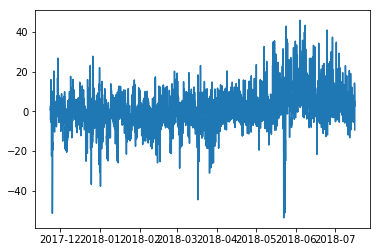

In [15]:
plt.plot(error)

In [16]:
lstm_test_res

[77.68372964505274, 0.8057976250715778, 0.7903060035721283, 0.8212892465710273]

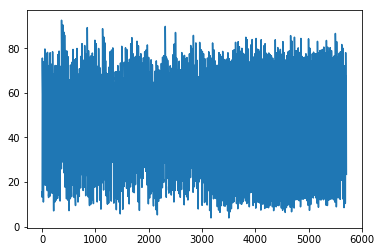

In [17]:
plt.plot(D_tilde + 40)

In [18]:
#np.mean(D_tilde + 40)
np.mean(L_tilde - 40)

7.055624157980406

(2, 22)

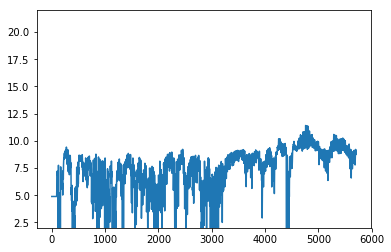

In [19]:
plt.plot(L_tilde - 40)
plt.ylim(bottom=2, top=22)

In [20]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [21]:
L_mean = moving_average(L_tilde, n=7*24)

(2, 22)

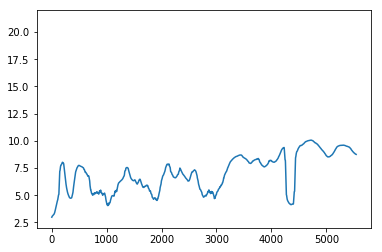

In [22]:
plt.plot(L_mean - 40)
plt.ylim(bottom=2, top=22)

In [23]:
# c) predict
D_tilde = gb.predict(W_comp)

# a) fitting model
L_tmp = X_comp - D_tilde

features, target, moments = transformer.preprocess_data(L_tmp)

# important with reshape for performance!
lstm_pred = np.array(lstm.predict(features), dtype='float64').reshape(-1)

L_tilde = (lstm_pred * moments['dist']) + moments['mean']

### STEP 3 - VALIDATION ###

# autocorrelation of errors

#have to subset len of sequence
error = transformer.calc_error(X_comp, D_tilde, L_tilde)

L_tilde = transformer.L_tilde_pad(L_tilde)
mse_true = np.mean(error**2)
param, conf_int_low, conf_int_high = error_autocorrelation(np.array(error))

lstm_test_res = [mse_true, param, conf_int_low, conf_int_high]

In [24]:
L_mean = moving_average(L_tilde, n=7*24)

(-2, 20)

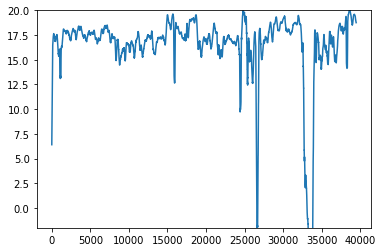

In [25]:
plt.plot(L_mean - 30)
plt.ylim(bottom=-2, top=20)